# Autoencoder
* https://medium.com/ai-academy-taiwan/what-are-autoencoders-175b474d74d1
* https://morvanzhou.github.io/tutorials/machine-learning/keras/2-6-autoencoder/
* https://github.com/MorvanZhou/tutorials/blob/master/kerasTUT/9-Autoencoder_example.py
* https://yaledatascience.github.io/2016/10/29/autoencoders.html
* https://blog.keras.io/building-autoencoders-in-keras.html

In [1]:
SAVE_FOLDER = 'grid_step5_4/'

In [2]:
# Basic import
import os
import sys
import json
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Helper function
def writeProgress(msg, count, total):
    sys.stdout.write(msg + "{:.2%}\r".format(count/total))
    sys.stdout.flush()
    
def newPath(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def read_json(src_path):
    with open(src_path, 'r') as json_file:
        data = json.load(json_file)
    return data

def write_json(data,dst_path):
    with open(dst_path, 'w') as outfile:
        json.dump(data, outfile)

In [4]:
from keras.models import Model
from keras.layers import Dense, Input
from keras import backend as K
from keras.callbacks import EarlyStopping

from sklearn import cluster, datasets, metrics
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Load data

In [5]:
df = pd.read_csv('./input/followingMatrix_over1.csv')
df

,movie,20thcenturyfox,a24,accessonline,adamsandler,adamshankman,agt,aldis_hodge,alecbaldwininsta,alexandrashipppp,...,willpowerpacker,willsmith,wmag,woodyharrelson,wwe,yahooentertainment,zacefron,zaziebeetz,zendaya,zoeydeutch
0,21bridgesmovie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47metersdown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,abeautifuldaymovie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,abominablemovie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,adastramovie,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,wrinklestheclown,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
161,xmenmovies,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
162,yardiefilm,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
163,yesterdaymovie,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
x_li = []
y_li = []
for i, row in df.iterrows():
    y_li.append(row['movie'])
    x_li.append(row.iloc[1:].tolist())
    
x = np.asarray(x_li)
y = np.asarray(y_li)
print(x.shape, y.shape)

(165, 472) (165,)


In [7]:
from sklearn.preprocessing import MinMaxScaler
print(x)
scaler = MinMaxScaler()
scaler.fit(x)
train_scaled = scaler.transform(x)
print(train_scaled.shape)
print(train_scaled)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]
(165, 472)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(train_scaled, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(132, 472) (33, 472)
(132,) (33,)


In [9]:
input_vec = x.shape[1]

In [10]:
def training(middle_dim, encoding_dim):
    # save setting
    SAVE_NAME = str(middle_dim) + '-' + str(encoding_dim) + 'dim'
    print(SAVE_NAME)
    newPath('./history/' + SAVE_FOLDER)
    newPath('./weight/' + SAVE_FOLDER)
    HISTORY_SAVE = './history/' + SAVE_FOLDER + SAVE_NAME + '.csv'
    WEIGHTS_SAVE = './weight/' + SAVE_FOLDER + SAVE_NAME + '.h5'
    
    K.clear_session()
    # model setting
    input_dim = Input(shape = (input_vec, ))

    # Encoder Layers
    encoded1 = Dense(middle_dim, activation = 'relu')(input_dim)
    encoded2 = Dense(encoding_dim, activation = 'relu')(encoded1)

    # Decoder Layers
    decoded1 = Dense(middle_dim, activation = 'relu')(encoded2)
    decoded2 = Dense(input_vec, activation = 'sigmoid')(decoded1)

    # Combine Encoder and Deocder layers
    autoencoder = Model(inputs = input_dim, outputs = decoded2)
    autoencoder.compile(optimizer = 'Adam', loss = 'binary_crossentropy')
    
    autoencoder.summary()

    # start training
    callbacks = [EarlyStopping(monitor='val_loss')]
    history = autoencoder.fit(X_train, X_train, epochs = 100, batch_size = 50, 
                              validation_data = (X_test, X_test),shuffle = True, callbacks=callbacks)
    
    # save weight
    autoencoder.save(WEIGHTS_SAVE)
    
    # save history
    # acc = history.history['acc']
    # val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    his_df = pd.DataFrame(data = {
        'Epoch' : epochs,
        'Loss' : loss,
    #     'Acc' : acc,
        'Val_loss' : val_loss#,
    #     'Val_acc' : val_acc
    })
    his_df = his_df[['Epoch', 'Loss','Val_loss']]
    his_df.to_csv(HISTORY_SAVE, index = False)
    
    
    # encoding feature
    encoder = Model(inputs = input_dim, outputs = encoded2)

    encoded_train = pd.DataFrame(encoder.predict(train_scaled))
    userContent=np.array(encoded_train)

    encoded_train = encoded_train.add_prefix('feature_')
    print(encoded_train.shape)

    # save dataframe
    encoded_train['movie'] = df['movie']
    encoded_train = encoded_train.set_index('movie')
    newPath('./output/' + SAVE_FOLDER)
    encoded_train.to_csv('./output/' + SAVE_FOLDER + SAVE_NAME + '.csv')
    
    # silhouette part
    silhouette_avgs = []
    ks = range(2, 30)

    for k in ks:
        kmeans_fit = cluster.KMeans(n_clusters = k).fit(encoded_train)
        cluster_labels = kmeans_fit.labels_
        silhouette_avg = metrics.silhouette_score(train_scaled, cluster_labels)
        silhouette_avgs.append(silhouette_avg)

    # 作圖並印出 k = 2 到 30 的績效
    plt.bar(ks, silhouette_avgs)
    plt.show()
    newPath('./score/' + SAVE_FOLDER)
    write_json(silhouette_avgs, './score/' + SAVE_FOLDER + SAVE_NAME + '.json')
    
    # cosine_similarity part
    cos = cosine_similarity(encoded_train)
#     print(cos.shape)
    
    cos_df = pd.DataFrame(cos, index = df['movie'], columns = df['movie'])
    newPath('./cosine_similarity/' + SAVE_FOLDER)
    cos_df.to_csv('./cosine_similarity/'+ SAVE_FOLDER + SAVE_NAME + '_cos.csv')
    print('==================================================')

In [11]:
search_list1 = [i for i in range(100, 0, -10)]
search_list1

[100, 90, 80, 70, 60, 50, 40, 30, 20, 10]

In [12]:
search_list2 = [i for i in range(50, 0, -5)]
search_list2

[50, 45, 40, 35, 30, 25, 20, 15, 10, 5]

100-50dim
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 105,122
Trainable params: 105,122
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cas

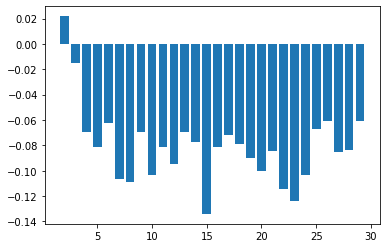

100-45dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 45)                4545      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4600      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 104,117
Trainable params: 104,117
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 960us/

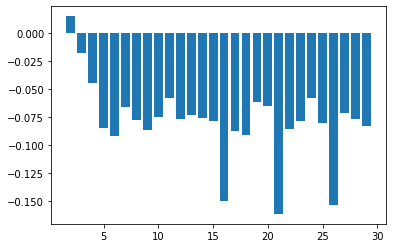

100-40dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                4040      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 103,112
Trainable params: 103,112
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 971us/

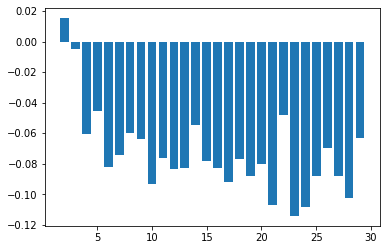

100-35dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 35)                3535      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3600      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 102,107
Trainable params: 102,107
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/st

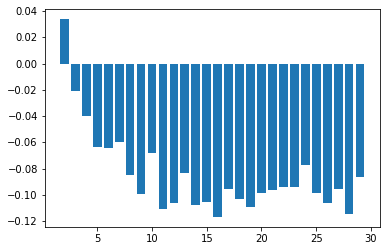

100-30dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                3030      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               3100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 101,102
Trainable params: 101,102
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 954us/

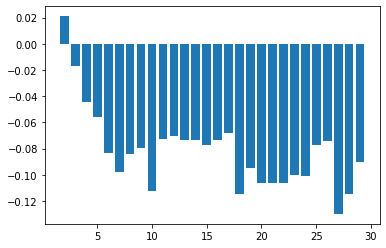

100-25dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2525      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2600      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 100,097
Trainable params: 100,097
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 984us/

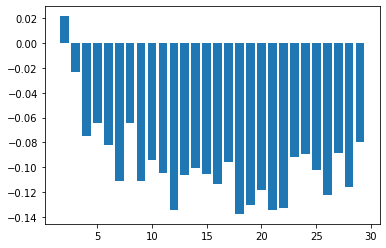

100-20dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 99,092
Trainable params: 99,092
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step

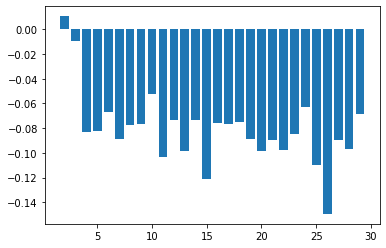

100-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1515      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1600      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 98,087
Trainable params: 98,087
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 979us/st

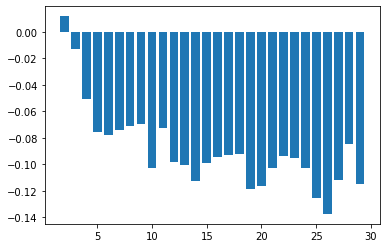

100-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 97,082
Trainable params: 97,082
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 969us/st

Epoch 70/100
132/132 [==============================] - 0s 56us/step - loss: 0.0688 - val_loss: 0.0846
Epoch 71/100
132/132 [==============================] - 0s 52us/step - loss: 0.0687 - val_loss: 0.0845
Epoch 72/100
132/132 [==============================] - 0s 57us/step - loss: 0.0685 - val_loss: 0.0844
Epoch 73/100
132/132 [==============================] - 0s 60us/step - loss: 0.0683 - val_loss: 0.0843
Epoch 74/100
132/132 [==============================] - 0s 56us/step - loss: 0.0681 - val_loss: 0.0842
Epoch 75/100
132/132 [==============================] - 0s 58us/step - loss: 0.0679 - val_loss: 0.0841
Epoch 76/100
132/132 [==============================] - 0s 54us/step - loss: 0.0677 - val_loss: 0.0840
Epoch 77/100
132/132 [==============================] - 0s 56us/step - loss: 0.0676 - val_loss: 0.0839
Epoch 78/100
132/132 [==============================] - 0s 52us/step - loss: 0.0674 - val_loss: 0.0838
Epoch 79/100
132/132 [==============================] - 0s 53us/step - lo

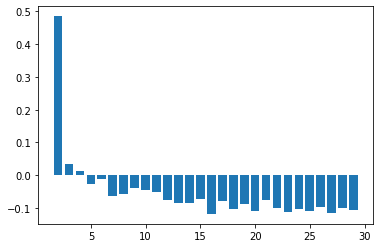

100-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               47300     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               47672     
Total params: 96,077
Trainable params: 96,077
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

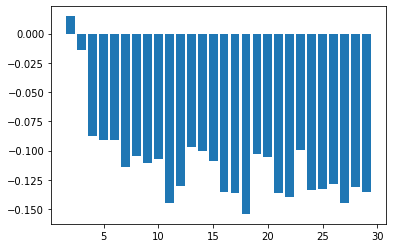

90-50dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4550      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                4590      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 94,662
Trainable params: 94,662
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 963us/ste

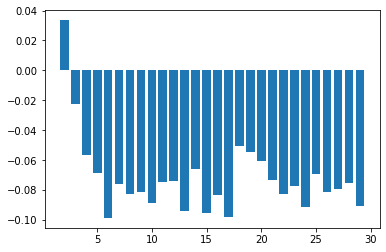

90-45dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 45)                4095      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                4140      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 93,757
Trainable params: 93,757
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 987us/ste

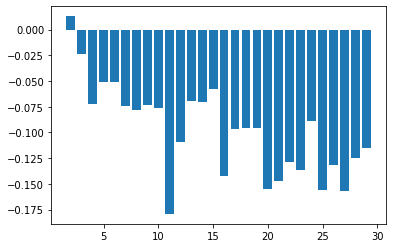

90-40dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3640      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                3690      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 92,852
Trainable params: 92,852
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

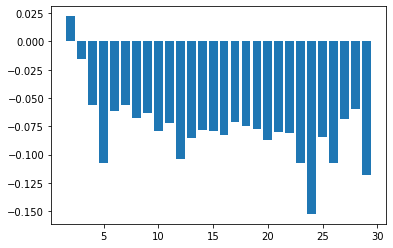

90-35dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 35)                3185      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                3240      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 91,947
Trainable params: 91,947
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

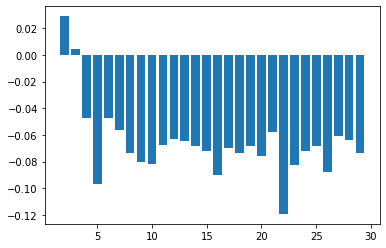

90-30dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2730      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                2790      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 91,042
Trainable params: 91,042
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 962us/ste

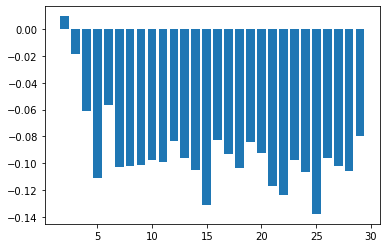

90-25dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2275      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                2340      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 90,137
Trainable params: 90,137
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

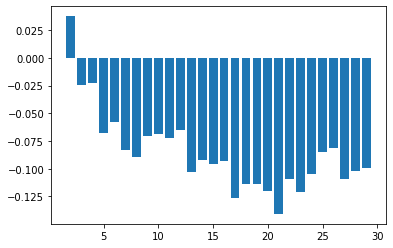

90-20dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1820      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                1890      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 89,232
Trainable params: 89,232
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 953us/ste

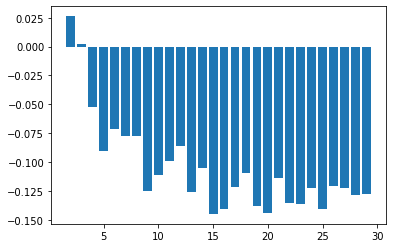

90-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1365      
_________________________________________________________________
dense_3 (Dense)              (None, 90)                1440      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 88,327
Trainable params: 88,327
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 958us/ste

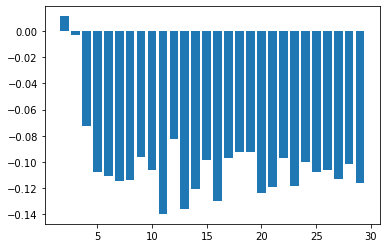

90-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                910       
_________________________________________________________________
dense_3 (Dense)              (None, 90)                990       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 87,422
Trainable params: 87,422
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

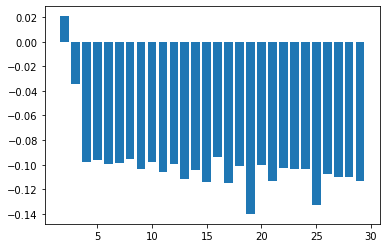

90-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 90)                42570     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 455       
_________________________________________________________________
dense_3 (Dense)              (None, 90)                540       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               42952     
Total params: 86,517
Trainable params: 86,517
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 969us/step

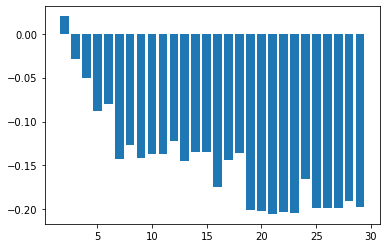

80-50dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                4050      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                4080      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 84,202
Trainable params: 84,202
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

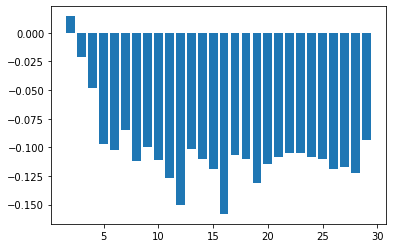

80-45dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 45)                3645      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3680      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 83,397
Trainable params: 83,397
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 990us/ste

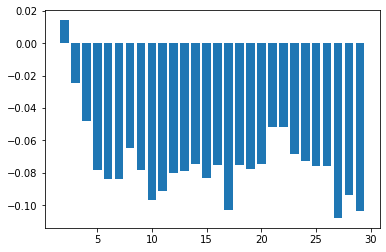

80-40dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                3240      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                3280      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 82,592
Trainable params: 82,592
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 971us/ste

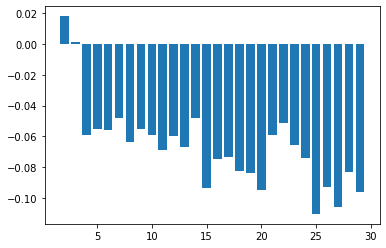

80-35dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 35)                2835      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2880      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 81,787
Trainable params: 81,787
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 950us/ste

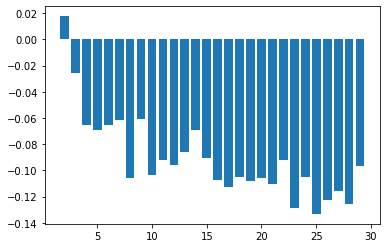

80-30dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2430      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2480      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 80,982
Trainable params: 80,982
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 967us/ste

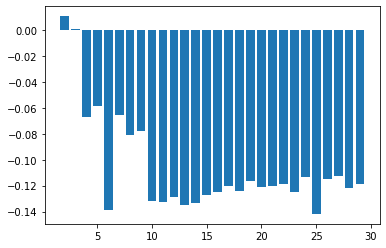

80-25dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                2025      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 80,177
Trainable params: 80,177
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 955us/ste

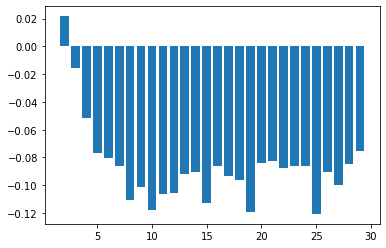

80-20dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1620      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1680      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 79,372
Trainable params: 79,372
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 947us/ste

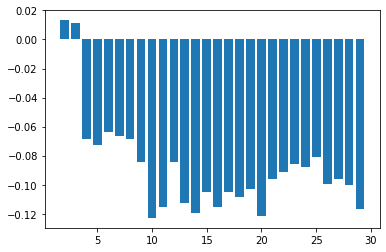

80-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1215      
_________________________________________________________________
dense_3 (Dense)              (None, 80)                1280      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 78,567
Trainable params: 78,567
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

132/132 [==============================] - 0s 68us/step - loss: 0.0691 - val_loss: 0.0846
Epoch 70/100
132/132 [==============================] - 0s 71us/step - loss: 0.0688 - val_loss: 0.0844
Epoch 71/100
132/132 [==============================] - 0s 65us/step - loss: 0.0685 - val_loss: 0.0843
Epoch 72/100
132/132 [==============================] - 0s 67us/step - loss: 0.0683 - val_loss: 0.0842
Epoch 73/100
132/132 [==============================] - ETA: 0s - loss: 0.080 - 0s 63us/step - loss: 0.0680 - val_loss: 0.0840
Epoch 74/100
132/132 [==============================] - 0s 65us/step - loss: 0.0678 - val_loss: 0.0840
Epoch 75/100
132/132 [==============================] - 0s 62us/step - loss: 0.0675 - val_loss: 0.0839
Epoch 76/100
132/132 [==============================] - 0s 59us/step - loss: 0.0672 - val_loss: 0.0838
Epoch 77/100
132/132 [==============================] - 0s 54us/step - loss: 0.0669 - val_loss: 0.0838
Epoch 78/100
132/132 [==============================] - 0s 59u

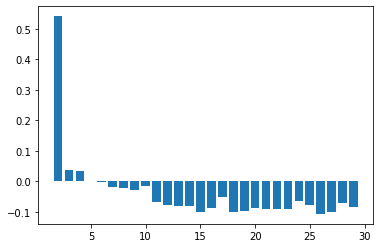

80-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                810       
_________________________________________________________________
dense_3 (Dense)              (None, 80)                880       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 77,762
Trainable params: 77,762
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 973us/ste

Epoch 70/100
132/132 [==============================] - 0s 60us/step - loss: 0.0688 - val_loss: 0.0845
Epoch 71/100
132/132 [==============================] - 0s 56us/step - loss: 0.0686 - val_loss: 0.0844
Epoch 72/100
132/132 [==============================] - ETA: 0s - loss: 0.056 - 0s 54us/step - loss: 0.0683 - val_loss: 0.0843
Epoch 73/100
132/132 [==============================] - 0s 57us/step - loss: 0.0680 - val_loss: 0.0843
Epoch 74/100
132/132 [==============================] - 0s 54us/step - loss: 0.0678 - val_loss: 0.0842
Epoch 75/100
132/132 [==============================] - 0s 58us/step - loss: 0.0675 - val_loss: 0.0842
Epoch 76/100
132/132 [==============================] - ETA: 0s - loss: 0.062 - 0s 58us/step - loss: 0.0672 - val_loss: 0.0842
Epoch 77/100
132/132 [==============================] - 0s 61us/step - loss: 0.0669 - val_loss: 0.0842
Epoch 78/100
132/132 [==============================] - 0s 56us/step - loss: 0.0666 - val_loss: 0.0841
Epoch 79/100
132/132 [===

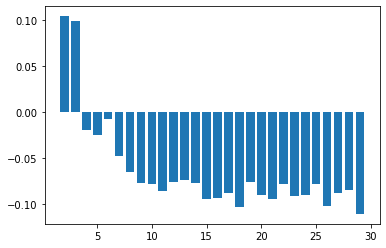

80-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 80)                37840     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 405       
_________________________________________________________________
dense_3 (Dense)              (None, 80)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               38232     
Total params: 76,957
Trainable params: 76,957
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 952us/step

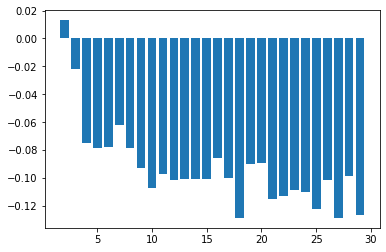

70-50dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3550      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                3570      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 73,742
Trainable params: 73,742
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

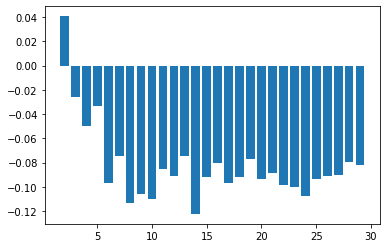

70-45dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 45)                3195      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                3220      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 73,037
Trainable params: 73,037
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 957us/ste

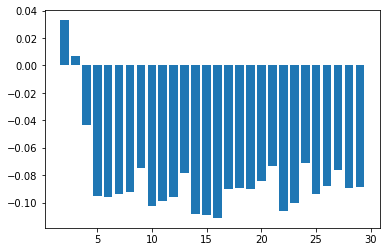

70-40dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2840      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                2870      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 72,332
Trainable params: 72,332
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 977us/ste

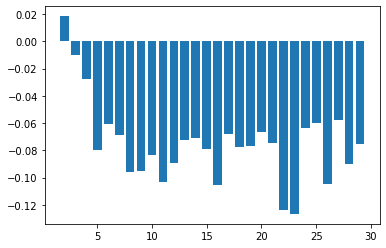

70-35dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 35)                2485      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                2520      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 71,627
Trainable params: 71,627
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

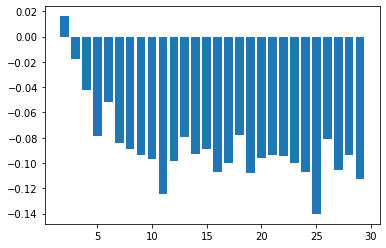

70-30dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                2130      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                2170      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 70,922
Trainable params: 70,922
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 959us/ste

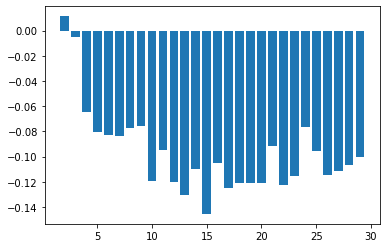

70-25dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1775      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                1820      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 70,217
Trainable params: 70,217
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 996us/ste

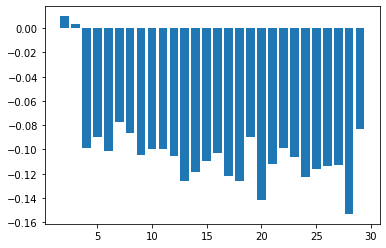

70-20dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1420      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                1470      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 69,512
Trainable params: 69,512
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

Epoch 70/100
132/132 [==============================] - 0s 68us/step - loss: 0.0655 - val_loss: 0.0838
Epoch 71/100
132/132 [==============================] - 0s 59us/step - loss: 0.0652 - val_loss: 0.0838
Epoch 72/100
132/132 [==============================] - 0s 59us/step - loss: 0.0648 - val_loss: 0.0837
Epoch 73/100
132/132 [==============================] - 0s 63us/step - loss: 0.0645 - val_loss: 0.0836
Epoch 74/100
132/132 [==============================] - 0s 60us/step - loss: 0.0641 - val_loss: 0.0835
Epoch 75/100
132/132 [==============================] - 0s 63us/step - loss: 0.0638 - val_loss: 0.0834
Epoch 76/100
132/132 [==============================] - 0s 61us/step - loss: 0.0635 - val_loss: 0.0834
Epoch 77/100
132/132 [==============================] - 0s 59us/step - loss: 0.0633 - val_loss: 0.0833
Epoch 78/100
132/132 [==============================] - 0s 59us/step - loss: 0.0629 - val_loss: 0.0832
Epoch 79/100
132/132 [==============================] - 0s 67us/step - lo

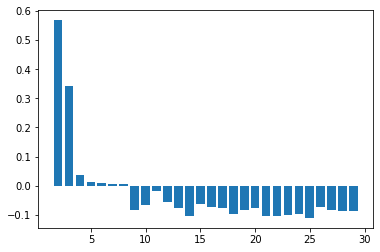

70-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                1065      
_________________________________________________________________
dense_3 (Dense)              (None, 70)                1120      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 68,807
Trainable params: 68,807
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

132/132 [==============================] - 0s 55us/step - loss: 0.0680 - val_loss: 0.0868
Epoch 70/100
132/132 [==============================] - 0s 56us/step - loss: 0.0677 - val_loss: 0.0868
Epoch 71/100
132/132 [==============================] - 0s 55us/step - loss: 0.0674 - val_loss: 0.0867
Epoch 72/100
132/132 [==============================] - 0s 55us/step - loss: 0.0671 - val_loss: 0.0866
Epoch 73/100
132/132 [==============================] - 0s 55us/step - loss: 0.0667 - val_loss: 0.0866
Epoch 74/100
132/132 [==============================] - 0s 56us/step - loss: 0.0664 - val_loss: 0.0866
(165, 15)


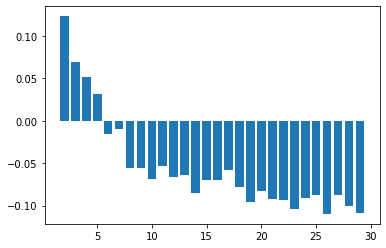

70-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                710       
_________________________________________________________________
dense_3 (Dense)              (None, 70)                770       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 68,102
Trainable params: 68,102
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 959us/ste

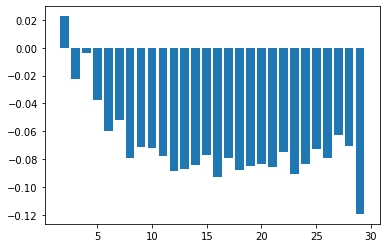

70-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 70)                33110     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 355       
_________________________________________________________________
dense_3 (Dense)              (None, 70)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               33512     
Total params: 67,397
Trainable params: 67,397
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step -

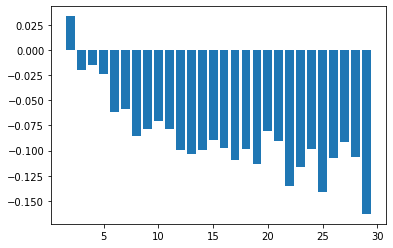

60-50dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3050      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                3060      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 63,282
Trainable params: 63,282
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 941us/ste

Epoch 70/100
132/132 [==============================] - 0s 56us/step - loss: 0.0700 - val_loss: 0.0785
Epoch 71/100
132/132 [==============================] - 0s 61us/step - loss: 0.0699 - val_loss: 0.0784
Epoch 72/100
132/132 [==============================] - 0s 64us/step - loss: 0.0698 - val_loss: 0.0784
Epoch 73/100
132/132 [==============================] - 0s 65us/step - loss: 0.0696 - val_loss: 0.0783
Epoch 74/100
132/132 [==============================] - 0s 60us/step - loss: 0.0695 - val_loss: 0.0783
Epoch 75/100
132/132 [==============================] - 0s 60us/step - loss: 0.0693 - val_loss: 0.0782
Epoch 76/100
132/132 [==============================] - 0s 63us/step - loss: 0.0692 - val_loss: 0.0782
Epoch 77/100
132/132 [==============================] - 0s 57us/step - loss: 0.0690 - val_loss: 0.0781
Epoch 78/100
132/132 [==============================] - 0s 59us/step - loss: 0.0689 - val_loss: 0.0781
Epoch 79/100
132/132 [==============================] - 0s 58us/step - lo

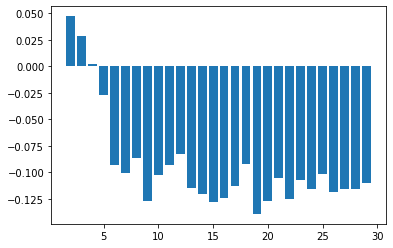

60-45dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 45)                2745      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2760      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 62,677
Trainable params: 62,677
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 987us/ste

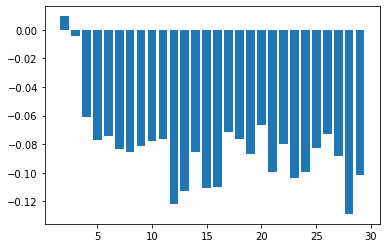

60-40dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2440      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2460      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 62,072
Trainable params: 62,072
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 970us/ste

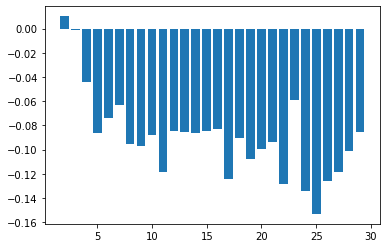

60-35dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 35)                2135      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                2160      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 61,467
Trainable params: 61,467
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 972us/ste

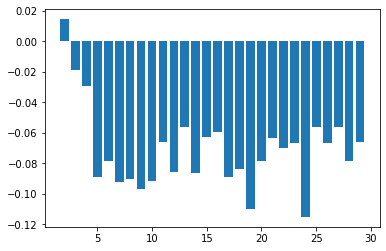

60-30dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1860      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 60,862
Trainable params: 60,862
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

132/132 [==============================] - 0s 58us/step - loss: 0.0659 - val_loss: 0.0867
(165, 30)


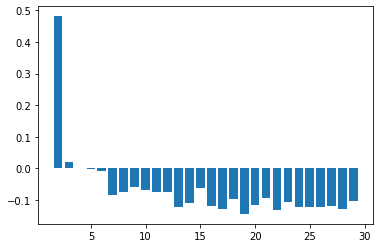

60-25dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1525      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1560      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 60,257
Trainable params: 60,257
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 967us/ste

Epoch 70/100
132/132 [==============================] - 0s 58us/step - loss: 0.0671 - val_loss: 0.0831
Epoch 71/100
132/132 [==============================] - 0s 60us/step - loss: 0.0669 - val_loss: 0.0830
Epoch 72/100
132/132 [==============================] - 0s 61us/step - loss: 0.0666 - val_loss: 0.0830
Epoch 73/100
132/132 [==============================] - 0s 61us/step - loss: 0.0663 - val_loss: 0.0829
Epoch 74/100
132/132 [==============================] - 0s 58us/step - loss: 0.0661 - val_loss: 0.0828
Epoch 75/100
132/132 [==============================] - 0s 62us/step - loss: 0.0658 - val_loss: 0.0826
Epoch 76/100
132/132 [==============================] - 0s 61us/step - loss: 0.0655 - val_loss: 0.0826
Epoch 77/100
132/132 [==============================] - 0s 63us/step - loss: 0.0653 - val_loss: 0.0825
Epoch 78/100
132/132 [==============================] - 0s 59us/step - loss: 0.0650 - val_loss: 0.0824
Epoch 79/100
132/132 [==============================] - 0s 58us/step - lo

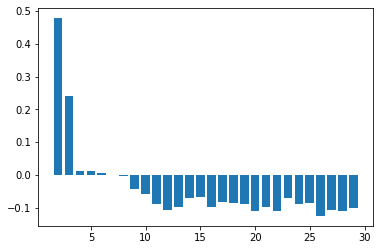

60-20dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1220      
_________________________________________________________________
dense_3 (Dense)              (None, 60)                1260      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 59,652
Trainable params: 59,652
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 964us/ste

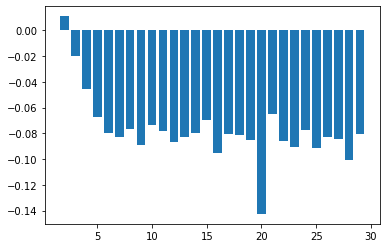

60-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                915       
_________________________________________________________________
dense_3 (Dense)              (None, 60)                960       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 59,047
Trainable params: 59,047
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

Epoch 70/100
132/132 [==============================] - 0s 55us/step - loss: 0.0703 - val_loss: 0.0853
Epoch 71/100
132/132 [==============================] - 0s 57us/step - loss: 0.0701 - val_loss: 0.0851
Epoch 72/100
132/132 [==============================] - 0s 56us/step - loss: 0.0700 - val_loss: 0.0850
Epoch 73/100
132/132 [==============================] - 0s 56us/step - loss: 0.0698 - val_loss: 0.0849
Epoch 74/100
132/132 [==============================] - 0s 55us/step - loss: 0.0697 - val_loss: 0.0848
Epoch 75/100
132/132 [==============================] - 0s 52us/step - loss: 0.0695 - val_loss: 0.0847
Epoch 76/100
132/132 [==============================] - 0s 54us/step - loss: 0.0694 - val_loss: 0.0847
Epoch 77/100
132/132 [==============================] - 0s 53us/step - loss: 0.0692 - val_loss: 0.0846
Epoch 78/100
132/132 [==============================] - 0s 56us/step - loss: 0.0691 - val_loss: 0.0846
Epoch 79/100
132/132 [==============================] - 0s 58us/step - lo

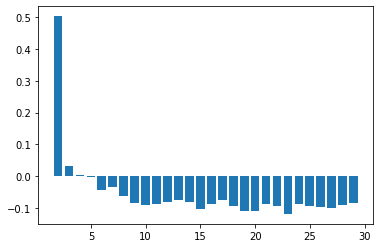

60-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                610       
_________________________________________________________________
dense_3 (Dense)              (None, 60)                660       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 58,442
Trainable params: 58,442
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 950us/ste

Epoch 70/100
132/132 [==============================] - 0s 56us/step - loss: 0.0702 - val_loss: 0.0836
Epoch 71/100
132/132 [==============================] - 0s 58us/step - loss: 0.0700 - val_loss: 0.0835
Epoch 72/100
132/132 [==============================] - 0s 59us/step - loss: 0.0697 - val_loss: 0.0834
Epoch 73/100
132/132 [==============================] - 0s 53us/step - loss: 0.0694 - val_loss: 0.0834
Epoch 74/100
132/132 [==============================] - 0s 57us/step - loss: 0.0692 - val_loss: 0.0833
Epoch 75/100
132/132 [==============================] - 0s 58us/step - loss: 0.0689 - val_loss: 0.0832
Epoch 76/100
132/132 [==============================] - 0s 54us/step - loss: 0.0686 - val_loss: 0.0830
Epoch 77/100
132/132 [==============================] - 0s 62us/step - loss: 0.0683 - val_loss: 0.0830
Epoch 78/100
132/132 [==============================] - 0s 57us/step - loss: 0.0681 - val_loss: 0.0829
Epoch 79/100
132/132 [==============================] - 0s 58us/step - lo

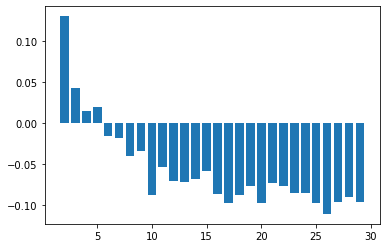

60-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                28380     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 305       
_________________________________________________________________
dense_3 (Dense)              (None, 60)                360       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               28792     
Total params: 57,837
Trainable params: 57,837
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 947us/step

Epoch 70/100
132/132 [==============================] - 0s 51us/step - loss: 0.0730 - val_loss: 0.0889
Epoch 71/100
132/132 [==============================] - 0s 54us/step - loss: 0.0728 - val_loss: 0.0888
Epoch 72/100
132/132 [==============================] - 0s 57us/step - loss: 0.0727 - val_loss: 0.0887
Epoch 73/100
132/132 [==============================] - 0s 56us/step - loss: 0.0726 - val_loss: 0.0886
Epoch 74/100
132/132 [==============================] - 0s 53us/step - loss: 0.0725 - val_loss: 0.0885
Epoch 75/100
132/132 [==============================] - 0s 53us/step - loss: 0.0723 - val_loss: 0.0884
Epoch 76/100
132/132 [==============================] - 0s 52us/step - loss: 0.0722 - val_loss: 0.0883
Epoch 77/100
132/132 [==============================] - 0s 56us/step - loss: 0.0721 - val_loss: 0.0882
Epoch 78/100
132/132 [==============================] - 0s 56us/step - loss: 0.0720 - val_loss: 0.0881
Epoch 79/100
132/132 [==============================] - 0s 56us/step - lo

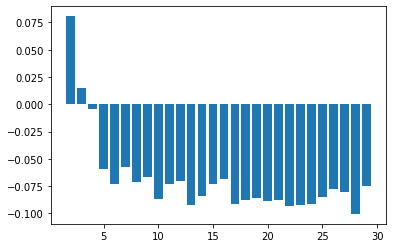

50-45dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 45)                2295      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2300      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 52,317
Trainable params: 52,317
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

Epoch 70/100
132/132 [==============================] - 0s 57us/step - loss: 0.0714 - val_loss: 0.0851
Epoch 71/100
132/132 [==============================] - 0s 56us/step - loss: 0.0713 - val_loss: 0.0850
Epoch 72/100
132/132 [==============================] - 0s 56us/step - loss: 0.0712 - val_loss: 0.0850
Epoch 73/100
132/132 [==============================] - 0s 53us/step - loss: 0.0711 - val_loss: 0.0849
Epoch 74/100
132/132 [==============================] - 0s 54us/step - loss: 0.0711 - val_loss: 0.0848
Epoch 75/100
132/132 [==============================] - 0s 52us/step - loss: 0.0710 - val_loss: 0.0847
Epoch 76/100
132/132 [==============================] - 0s 52us/step - loss: 0.0709 - val_loss: 0.0846
Epoch 77/100
132/132 [==============================] - 0s 55us/step - loss: 0.0708 - val_loss: 0.0845
Epoch 78/100
132/132 [==============================] - 0s 54us/step - loss: 0.0708 - val_loss: 0.0845
Epoch 79/100
132/132 [==============================] - 0s 53us/step - lo

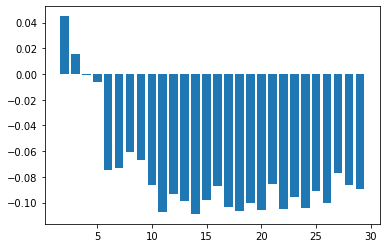

50-40dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                2040      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2050      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 51,812
Trainable params: 51,812
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 973us/ste

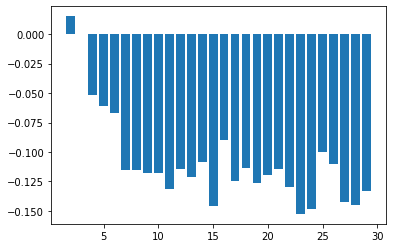

50-35dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 35)                1785      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1800      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 51,307
Trainable params: 51,307
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

Epoch 70/100
132/132 [==============================] - 0s 63us/step - loss: 0.0702 - val_loss: 0.0824
Epoch 71/100
132/132 [==============================] - 0s 56us/step - loss: 0.0700 - val_loss: 0.0824
Epoch 72/100
132/132 [==============================] - 0s 55us/step - loss: 0.0699 - val_loss: 0.0823
Epoch 73/100
132/132 [==============================] - 0s 64us/step - loss: 0.0697 - val_loss: 0.0823
Epoch 74/100
132/132 [==============================] - 0s 59us/step - loss: 0.0695 - val_loss: 0.0823
Epoch 75/100
132/132 [==============================] - 0s 53us/step - loss: 0.0694 - val_loss: 0.0823
Epoch 76/100
132/132 [==============================] - 0s 62us/step - loss: 0.0692 - val_loss: 0.0823
Epoch 77/100
132/132 [==============================] - 0s 51us/step - loss: 0.0690 - val_loss: 0.0822
Epoch 78/100
132/132 [==============================] - 0s 59us/step - loss: 0.0688 - val_loss: 0.0822
Epoch 79/100
132/132 [==============================] - 0s 55us/step - lo

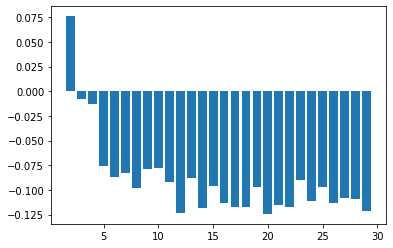

50-30dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1550      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 50,802
Trainable params: 50,802
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

Epoch 70/100
132/132 [==============================] - 0s 53us/step - loss: 0.0710 - val_loss: 0.0856
Epoch 71/100
132/132 [==============================] - 0s 56us/step - loss: 0.0709 - val_loss: 0.0855
Epoch 72/100
132/132 [==============================] - 0s 54us/step - loss: 0.0707 - val_loss: 0.0854
Epoch 73/100
132/132 [==============================] - 0s 51us/step - loss: 0.0705 - val_loss: 0.0854
Epoch 74/100
132/132 [==============================] - 0s 55us/step - loss: 0.0703 - val_loss: 0.0853
Epoch 75/100
132/132 [==============================] - 0s 52us/step - loss: 0.0701 - val_loss: 0.0853
Epoch 76/100
132/132 [==============================] - 0s 55us/step - loss: 0.0699 - val_loss: 0.0852
Epoch 77/100
132/132 [==============================] - 0s 56us/step - loss: 0.0697 - val_loss: 0.0851
Epoch 78/100
132/132 [==============================] - 0s 55us/step - loss: 0.0696 - val_loss: 0.0850
Epoch 79/100
132/132 [==============================] - 0s 59us/step - lo

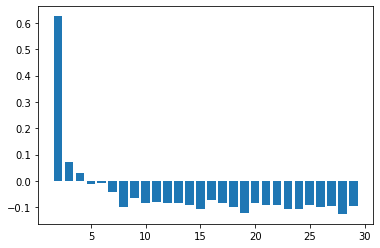

50-25dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1300      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 50,297
Trainable params: 50,297
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 960us/ste

132/132 [==============================] - 0s 60us/step - loss: 0.0677 - val_loss: 0.0855
Epoch 70/100
132/132 [==============================] - 0s 59us/step - loss: 0.0673 - val_loss: 0.0855
Epoch 71/100
132/132 [==============================] - 0s 59us/step - loss: 0.0671 - val_loss: 0.0854
Epoch 72/100
132/132 [==============================] - 0s 58us/step - loss: 0.0668 - val_loss: 0.0853
Epoch 73/100
132/132 [==============================] - 0s 59us/step - loss: 0.0665 - val_loss: 0.0852
Epoch 74/100
132/132 [==============================] - 0s 60us/step - loss: 0.0663 - val_loss: 0.0852
Epoch 75/100
132/132 [==============================] - 0s 59us/step - loss: 0.0659 - val_loss: 0.0851
Epoch 76/100
132/132 [==============================] - 0s 63us/step - loss: 0.0657 - val_loss: 0.0850
Epoch 77/100
132/132 [==============================] - 0s 61us/step - loss: 0.0654 - val_loss: 0.0849
Epoch 78/100
132/132 [==============================] - 0s 60us/step - loss: 0.0651 - 

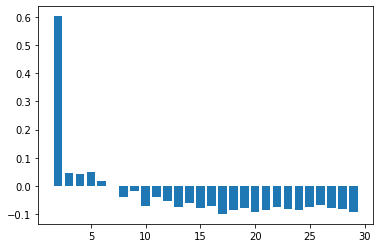

50-20dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 49,792
Trainable params: 49,792
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 958us/ste

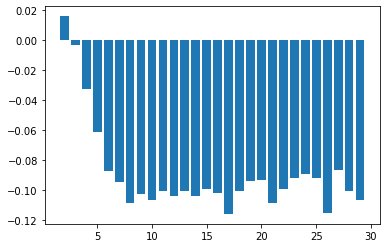

50-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                765       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                800       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 49,287
Trainable params: 49,287
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 950us/ste

132/132 [==============================] - 0s 59us/step - loss: 0.0715 - val_loss: 0.0831
Epoch 70/100
132/132 [==============================] - 0s 58us/step - loss: 0.0713 - val_loss: 0.0830
Epoch 71/100
132/132 [==============================] - 0s 60us/step - loss: 0.0711 - val_loss: 0.0829
Epoch 72/100
132/132 [==============================] - 0s 64us/step - loss: 0.0709 - val_loss: 0.0828
Epoch 73/100
132/132 [==============================] - 0s 60us/step - loss: 0.0707 - val_loss: 0.0827
Epoch 74/100
132/132 [==============================] - 0s 60us/step - loss: 0.0705 - val_loss: 0.0827
Epoch 75/100
132/132 [==============================] - 0s 60us/step - loss: 0.0703 - val_loss: 0.0826
Epoch 76/100
132/132 [==============================] - 0s 60us/step - loss: 0.0700 - val_loss: 0.0826
Epoch 77/100
132/132 [==============================] - 0s 58us/step - loss: 0.0698 - val_loss: 0.0826
Epoch 78/100
132/132 [==============================] - 0s 61us/step - loss: 0.0696 - 

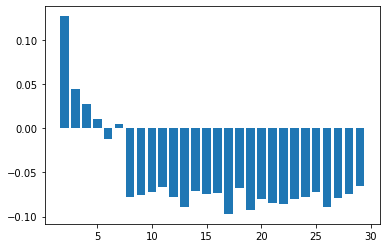

50-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 48,782
Trainable params: 48,782
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1ms/step 

Epoch 70/100
132/132 [==============================] - 0s 57us/step - loss: 0.0727 - val_loss: 0.0924
Epoch 71/100
132/132 [==============================] - 0s 54us/step - loss: 0.0725 - val_loss: 0.0922
Epoch 72/100
132/132 [==============================] - 0s 54us/step - loss: 0.0723 - val_loss: 0.0921
Epoch 73/100
132/132 [==============================] - 0s 54us/step - loss: 0.0720 - val_loss: 0.0920
Epoch 74/100
132/132 [==============================] - 0s 58us/step - loss: 0.0717 - val_loss: 0.0919
Epoch 75/100
132/132 [==============================] - 0s 57us/step - loss: 0.0714 - val_loss: 0.0918
Epoch 76/100
132/132 [==============================] - 0s 55us/step - loss: 0.0712 - val_loss: 0.0916
Epoch 77/100
132/132 [==============================] - 0s 56us/step - loss: 0.0709 - val_loss: 0.0915
Epoch 78/100
132/132 [==============================] - 0s 54us/step - loss: 0.0707 - val_loss: 0.0914
Epoch 79/100
132/132 [==============================] - 0s 53us/step - lo

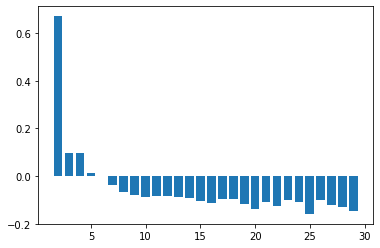

50-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                23650     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 255       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                300       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               24072     
Total params: 48,277
Trainable params: 48,277
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 959us/step

Epoch 70/100
132/132 [==============================] - 0s 53us/step - loss: 0.0736 - val_loss: 0.0915
Epoch 71/100
132/132 [==============================] - 0s 53us/step - loss: 0.0734 - val_loss: 0.0914
Epoch 72/100
132/132 [==============================] - 0s 55us/step - loss: 0.0732 - val_loss: 0.0913
Epoch 73/100
132/132 [==============================] - 0s 56us/step - loss: 0.0730 - val_loss: 0.0912
Epoch 74/100
132/132 [==============================] - 0s 56us/step - loss: 0.0728 - val_loss: 0.0910
Epoch 75/100
132/132 [==============================] - 0s 53us/step - loss: 0.0726 - val_loss: 0.0909
Epoch 76/100
132/132 [==============================] - 0s 52us/step - loss: 0.0724 - val_loss: 0.0908
Epoch 77/100
132/132 [==============================] - 0s 55us/step - loss: 0.0722 - val_loss: 0.0907
Epoch 78/100
132/132 [==============================] - 0s 53us/step - loss: 0.0720 - val_loss: 0.0906
Epoch 79/100
132/132 [==============================] - 0s 53us/step - lo

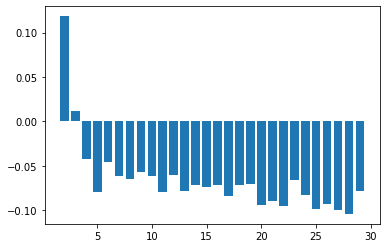

40-35dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 35)                1435      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1440      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 41,147
Trainable params: 41,147
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 952us/ste

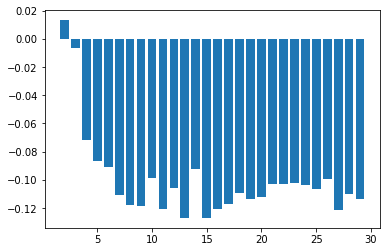

40-30dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 40,742
Trainable params: 40,742
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 957us/ste

Epoch 70/100
132/132 [==============================] - 0s 68us/step - loss: 0.0713 - val_loss: 0.0865
Epoch 71/100
132/132 [==============================] - 0s 69us/step - loss: 0.0711 - val_loss: 0.0863
Epoch 72/100
132/132 [==============================] - 0s 64us/step - loss: 0.0709 - val_loss: 0.0862
Epoch 73/100
132/132 [==============================] - 0s 68us/step - loss: 0.0708 - val_loss: 0.0861
Epoch 74/100
132/132 [==============================] - 0s 67us/step - loss: 0.0706 - val_loss: 0.0860
Epoch 75/100
132/132 [==============================] - 0s 63us/step - loss: 0.0704 - val_loss: 0.0859
Epoch 76/100
132/132 [==============================] - 0s 68us/step - loss: 0.0702 - val_loss: 0.0858
Epoch 77/100
132/132 [==============================] - 0s 65us/step - loss: 0.0700 - val_loss: 0.0858
Epoch 78/100
132/132 [==============================] - 0s 70us/step - loss: 0.0698 - val_loss: 0.0857
Epoch 79/100
132/132 [==============================] - 0s 67us/step - lo

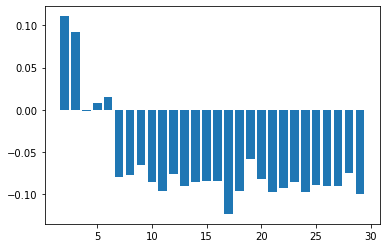

40-25dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                1025      
_________________________________________________________________
dense_3 (Dense)              (None, 40)                1040      
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 40,337
Trainable params: 40,337
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 943us/ste

132/132 [==============================] - 0s 58us/step - loss: 0.0720 - val_loss: 0.0857
Epoch 70/100
132/132 [==============================] - 0s 61us/step - loss: 0.0718 - val_loss: 0.0855
Epoch 71/100
132/132 [==============================] - 0s 60us/step - loss: 0.0717 - val_loss: 0.0854
Epoch 72/100
132/132 [==============================] - 0s 63us/step - loss: 0.0716 - val_loss: 0.0853
Epoch 73/100
132/132 [==============================] - 0s 58us/step - loss: 0.0715 - val_loss: 0.0852
Epoch 74/100
132/132 [==============================] - ETA: 0s - loss: 0.078 - 0s 60us/step - loss: 0.0714 - val_loss: 0.0852
Epoch 75/100
132/132 [==============================] - 0s 56us/step - loss: 0.0713 - val_loss: 0.0850
Epoch 76/100
132/132 [==============================] - 0s 60us/step - loss: 0.0712 - val_loss: 0.0849
Epoch 77/100
132/132 [==============================] - 0s 61us/step - loss: 0.0711 - val_loss: 0.0848
Epoch 78/100
132/132 [==============================] - 0s 59u

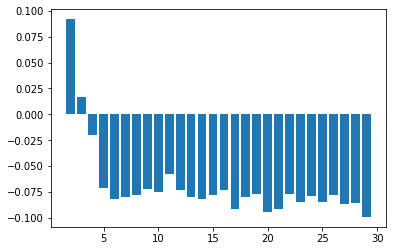

40-20dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 39,932
Trainable params: 39,932
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 969us/ste

Epoch 70/100
132/132 [==============================] - 0s 61us/step - loss: 0.0720 - val_loss: 0.0831
Epoch 71/100
132/132 [==============================] - 0s 68us/step - loss: 0.0719 - val_loss: 0.0829
Epoch 72/100
132/132 [==============================] - 0s 66us/step - loss: 0.0718 - val_loss: 0.0827
Epoch 73/100
132/132 [==============================] - 0s 70us/step - loss: 0.0717 - val_loss: 0.0826
Epoch 74/100
132/132 [==============================] - 0s 67us/step - loss: 0.0716 - val_loss: 0.0824
Epoch 75/100
132/132 [==============================] - 0s 64us/step - loss: 0.0715 - val_loss: 0.0823
Epoch 76/100
132/132 [==============================] - 0s 56us/step - loss: 0.0713 - val_loss: 0.0822
Epoch 77/100
132/132 [==============================] - 0s 66us/step - loss: 0.0712 - val_loss: 0.0821
Epoch 78/100
132/132 [==============================] - 0s 57us/step - loss: 0.0711 - val_loss: 0.0819
Epoch 79/100
132/132 [==============================] - 0s 63us/step - lo

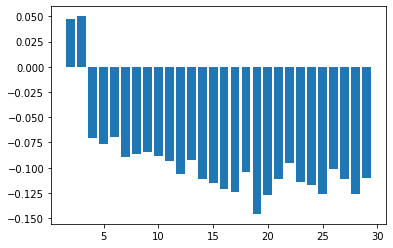

40-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                615       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 39,527
Trainable params: 39,527
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 1000us/st

Epoch 70/100
132/132 [==============================] - 0s 58us/step - loss: 0.0721 - val_loss: 0.0872
Epoch 71/100
132/132 [==============================] - 0s 59us/step - loss: 0.0719 - val_loss: 0.0870
Epoch 72/100
132/132 [==============================] - 0s 57us/step - loss: 0.0718 - val_loss: 0.0869
Epoch 73/100
132/132 [==============================] - 0s 60us/step - loss: 0.0716 - val_loss: 0.0868
Epoch 74/100
132/132 [==============================] - 0s 57us/step - loss: 0.0714 - val_loss: 0.0866
Epoch 75/100
132/132 [==============================] - 0s 60us/step - loss: 0.0712 - val_loss: 0.0865
Epoch 76/100
132/132 [==============================] - 0s 56us/step - loss: 0.0711 - val_loss: 0.0864
Epoch 77/100
132/132 [==============================] - 0s 62us/step - loss: 0.0709 - val_loss: 0.0863
Epoch 78/100
132/132 [==============================] - 0s 61us/step - loss: 0.0707 - val_loss: 0.0862
Epoch 79/100
132/132 [==============================] - 0s 66us/step - lo

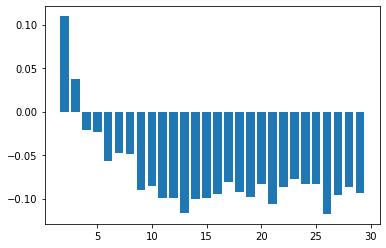

40-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                440       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 39,122
Trainable params: 39,122
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 979us/ste

132/132 [==============================] - 0s 76us/step - loss: 0.0721 - val_loss: 0.0901
Epoch 70/100
132/132 [==============================] - ETA: 0s - loss: 0.055 - 0s 66us/step - loss: 0.0720 - val_loss: 0.0900
Epoch 71/100
132/132 [==============================] - 0s 64us/step - loss: 0.0718 - val_loss: 0.0899
Epoch 72/100
132/132 [==============================] - 0s 66us/step - loss: 0.0716 - val_loss: 0.0897
Epoch 73/100
132/132 [==============================] - 0s 66us/step - loss: 0.0714 - val_loss: 0.0896
Epoch 74/100
132/132 [==============================] - 0s 67us/step - loss: 0.0713 - val_loss: 0.0894
Epoch 75/100
132/132 [==============================] - 0s 68us/step - loss: 0.0711 - val_loss: 0.0893
Epoch 76/100
132/132 [==============================] - 0s 65us/step - loss: 0.0709 - val_loss: 0.0891
Epoch 77/100
132/132 [==============================] - 0s 66us/step - loss: 0.0708 - val_loss: 0.0890
Epoch 78/100
132/132 [==============================] - 0s 68u

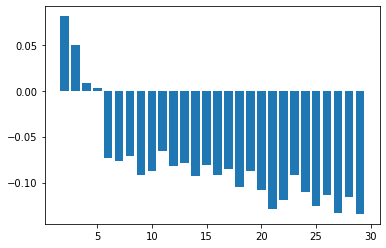

40-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                18920     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 205       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               19352     
Total params: 38,717
Trainable params: 38,717
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 944us/step

132/132 [==============================] - 0s 61us/step - loss: 0.0758 - val_loss: 0.0928
Epoch 70/100
132/132 [==============================] - 0s 54us/step - loss: 0.0755 - val_loss: 0.0927
Epoch 71/100
132/132 [==============================] - 0s 59us/step - loss: 0.0752 - val_loss: 0.0926
Epoch 72/100
132/132 [==============================] - 0s 57us/step - loss: 0.0749 - val_loss: 0.0925
Epoch 73/100
132/132 [==============================] - 0s 59us/step - loss: 0.0746 - val_loss: 0.0924
Epoch 74/100
132/132 [==============================] - 0s 56us/step - loss: 0.0744 - val_loss: 0.0923
Epoch 75/100
132/132 [==============================] - 0s 58us/step - loss: 0.0741 - val_loss: 0.0922
Epoch 76/100
132/132 [==============================] - 0s 55us/step - loss: 0.0738 - val_loss: 0.0921
Epoch 77/100
132/132 [==============================] - 0s 55us/step - loss: 0.0735 - val_loss: 0.0921
Epoch 78/100
132/132 [==============================] - 0s 57us/step - loss: 0.0733 - 

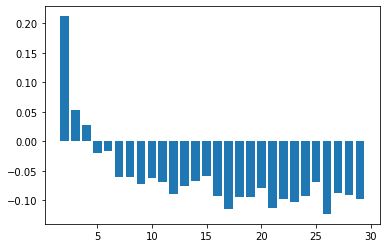

30-25dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                14190     
_________________________________________________________________
dense_2 (Dense)              (None, 25)                775       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                780       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               14632     
Total params: 30,377
Trainable params: 30,377
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 952us/ste

Epoch 70/100
132/132 [==============================] - 0s 55us/step - loss: 0.0728 - val_loss: 0.0829
Epoch 71/100
132/132 [==============================] - 0s 58us/step - loss: 0.0727 - val_loss: 0.0828
Epoch 72/100
132/132 [==============================] - 0s 55us/step - loss: 0.0726 - val_loss: 0.0827
Epoch 73/100
132/132 [==============================] - 0s 61us/step - loss: 0.0725 - val_loss: 0.0826
Epoch 74/100
132/132 [==============================] - 0s 54us/step - loss: 0.0724 - val_loss: 0.0825
Epoch 75/100
132/132 [==============================] - 0s 55us/step - loss: 0.0723 - val_loss: 0.0824
Epoch 76/100
132/132 [==============================] - ETA: 0s - loss: 0.058 - 0s 55us/step - loss: 0.0722 - val_loss: 0.0823
Epoch 77/100
132/132 [==============================] - 0s 55us/step - loss: 0.0721 - val_loss: 0.0822
Epoch 78/100
132/132 [==============================] - 0s 54us/step - loss: 0.0720 - val_loss: 0.0821
Epoch 79/100
132/132 [===========================

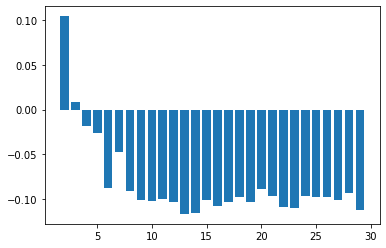

30-20dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                14190     
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                630       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               14632     
Total params: 30,072
Trainable params: 30,072
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 950us/ste

Epoch 70/100
132/132 [==============================] - 0s 61us/step - loss: 0.0714 - val_loss: 0.0887
Epoch 71/100
132/132 [==============================] - 0s 63us/step - loss: 0.0711 - val_loss: 0.0886
Epoch 72/100
132/132 [==============================] - 0s 56us/step - loss: 0.0709 - val_loss: 0.0885
Epoch 73/100
132/132 [==============================] - 0s 62us/step - loss: 0.0706 - val_loss: 0.0883
Epoch 74/100
132/132 [==============================] - 0s 57us/step - loss: 0.0704 - val_loss: 0.0881
Epoch 75/100
132/132 [==============================] - 0s 57us/step - loss: 0.0701 - val_loss: 0.0879
Epoch 76/100
132/132 [==============================] - 0s 55us/step - loss: 0.0699 - val_loss: 0.0878
Epoch 77/100
132/132 [==============================] - 0s 60us/step - loss: 0.0697 - val_loss: 0.0875
Epoch 78/100
132/132 [==============================] - 0s 63us/step - loss: 0.0694 - val_loss: 0.0873
Epoch 79/100
132/132 [==============================] - 0s 63us/step - lo

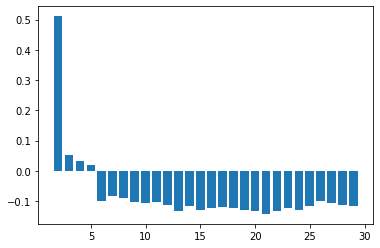

30-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                14190     
_________________________________________________________________
dense_2 (Dense)              (None, 15)                465       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                480       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               14632     
Total params: 29,767
Trainable params: 29,767
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 961us/ste

Epoch 70/100
132/132 [==============================] - 0s 58us/step - loss: 0.0730 - val_loss: 0.0854
Epoch 71/100
132/132 [==============================] - 0s 59us/step - loss: 0.0728 - val_loss: 0.0852
Epoch 72/100
132/132 [==============================] - 0s 60us/step - loss: 0.0726 - val_loss: 0.0850
Epoch 73/100
132/132 [==============================] - 0s 59us/step - loss: 0.0724 - val_loss: 0.0849
Epoch 74/100
132/132 [==============================] - 0s 59us/step - loss: 0.0722 - val_loss: 0.0848
Epoch 75/100
132/132 [==============================] - ETA: 0s - loss: 0.063 - 0s 56us/step - loss: 0.0721 - val_loss: 0.0846
Epoch 76/100
132/132 [==============================] - ETA: 0s - loss: 0.079 - 0s 57us/step - loss: 0.0719 - val_loss: 0.0844
Epoch 77/100
132/132 [==============================] - 0s 60us/step - loss: 0.0718 - val_loss: 0.0843
Epoch 78/100
132/132 [==============================] - 0s 60us/step - loss: 0.0716 - val_loss: 0.0842
Epoch 79/100
132/132 [===

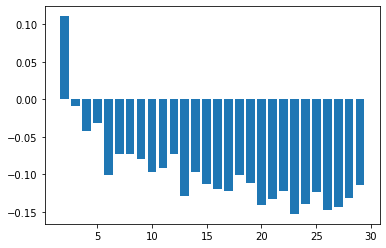

30-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                14190     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                310       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                330       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               14632     
Total params: 29,462
Trainable params: 29,462
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 962us/ste

Epoch 70/100
132/132 [==============================] - 0s 84us/step - loss: 0.0733 - val_loss: 0.0904
Epoch 71/100
132/132 [==============================] - 0s 90us/step - loss: 0.0732 - val_loss: 0.0903
Epoch 72/100
132/132 [==============================] - 0s 96us/step - loss: 0.0730 - val_loss: 0.0901
Epoch 73/100
132/132 [==============================] - 0s 94us/step - loss: 0.0728 - val_loss: 0.0900
Epoch 74/100
132/132 [==============================] - 0s 99us/step - loss: 0.0727 - val_loss: 0.0899
Epoch 75/100
132/132 [==============================] - 0s 97us/step - loss: 0.0725 - val_loss: 0.0898
Epoch 76/100
132/132 [==============================] - 0s 95us/step - loss: 0.0724 - val_loss: 0.0897
Epoch 77/100
132/132 [==============================] - 0s 93us/step - loss: 0.0722 - val_loss: 0.0896
Epoch 78/100
132/132 [==============================] - 0s 95us/step - loss: 0.0721 - val_loss: 0.0896
Epoch 79/100
132/132 [==============================] - 0s 92us/step - lo

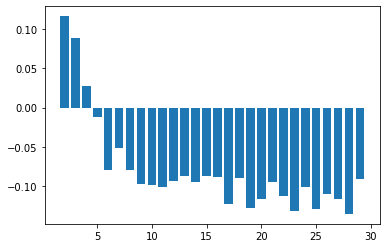

30-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                14190     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 155       
_________________________________________________________________
dense_3 (Dense)              (None, 30)                180       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               14632     
Total params: 29,157
Trainable params: 29,157
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 954us/step

Epoch 70/100
132/132 [==============================] - 0s 60us/step - loss: 0.0765 - val_loss: 0.0908
Epoch 71/100
132/132 [==============================] - 0s 69us/step - loss: 0.0763 - val_loss: 0.0906
Epoch 72/100
132/132 [==============================] - 0s 66us/step - loss: 0.0761 - val_loss: 0.0903
Epoch 73/100
132/132 [==============================] - 0s 59us/step - loss: 0.0759 - val_loss: 0.0901
Epoch 74/100
132/132 [==============================] - 0s 63us/step - loss: 0.0757 - val_loss: 0.0900
Epoch 75/100
132/132 [==============================] - 0s 59us/step - loss: 0.0756 - val_loss: 0.0898
Epoch 76/100
132/132 [==============================] - 0s 62us/step - loss: 0.0754 - val_loss: 0.0897
Epoch 77/100
132/132 [==============================] - 0s 67us/step - loss: 0.0752 - val_loss: 0.0895
Epoch 78/100
132/132 [==============================] - 0s 65us/step - loss: 0.0751 - val_loss: 0.0894
Epoch 79/100
132/132 [==============================] - 0s 59us/step - lo

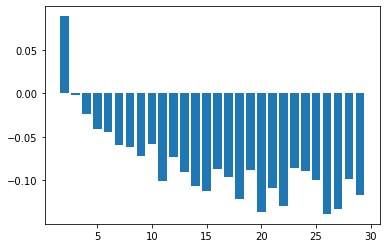

20-15dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                9460      
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               9912      
Total params: 20,007
Trainable params: 20,007
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 972us/ste

132/132 [==============================] - 0s 55us/step - loss: 0.0758 - val_loss: 0.0907
Epoch 70/100
132/132 [==============================] - 0s 52us/step - loss: 0.0757 - val_loss: 0.0906
Epoch 71/100
132/132 [==============================] - 0s 53us/step - loss: 0.0755 - val_loss: 0.0904
Epoch 72/100
132/132 [==============================] - 0s 55us/step - loss: 0.0753 - val_loss: 0.0903
Epoch 73/100
132/132 [==============================] - 0s 53us/step - loss: 0.0751 - val_loss: 0.0901
Epoch 74/100
132/132 [==============================] - 0s 53us/step - loss: 0.0750 - val_loss: 0.0900
Epoch 75/100
132/132 [==============================] - 0s 52us/step - loss: 0.0748 - val_loss: 0.0899
Epoch 76/100
132/132 [==============================] - 0s 60us/step - loss: 0.0747 - val_loss: 0.0898
Epoch 77/100
132/132 [==============================] - 0s 55us/step - loss: 0.0746 - val_loss: 0.0897
Epoch 78/100
132/132 [==============================] - 0s 55us/step - loss: 0.0744 - 

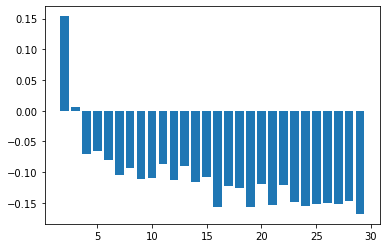

20-10dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                9460      
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               9912      
Total params: 19,802
Trainable params: 19,802
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 949us/ste

Epoch 70/100
132/132 [==============================] - 0s 60us/step - loss: 0.0769 - val_loss: 0.0922
Epoch 71/100
132/132 [==============================] - 0s 54us/step - loss: 0.0767 - val_loss: 0.0921
Epoch 72/100
132/132 [==============================] - 0s 58us/step - loss: 0.0764 - val_loss: 0.0919
Epoch 73/100
132/132 [==============================] - 0s 54us/step - loss: 0.0762 - val_loss: 0.0918
Epoch 74/100
132/132 [==============================] - 0s 58us/step - loss: 0.0760 - val_loss: 0.0916
Epoch 75/100
132/132 [==============================] - 0s 61us/step - loss: 0.0758 - val_loss: 0.0915
Epoch 76/100
132/132 [==============================] - 0s 54us/step - loss: 0.0756 - val_loss: 0.0914
Epoch 77/100
132/132 [==============================] - 0s 56us/step - loss: 0.0754 - val_loss: 0.0913
Epoch 78/100
132/132 [==============================] - 0s 61us/step - loss: 0.0752 - val_loss: 0.0912
Epoch 79/100
132/132 [==============================] - 0s 54us/step - lo

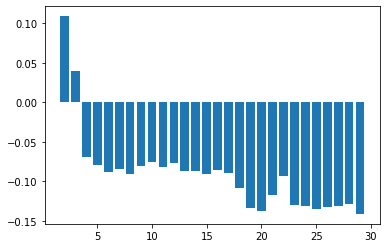

20-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                9460      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                120       
_________________________________________________________________
dense_4 (Dense)              (None, 472)               9912      
Total params: 19,597
Trainable params: 19,597
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 947us/step

Epoch 70/100
132/132 [==============================] - 0s 56us/step - loss: 0.0782 - val_loss: 0.0828
Epoch 71/100
132/132 [==============================] - 0s 60us/step - loss: 0.0779 - val_loss: 0.0826
Epoch 72/100
132/132 [==============================] - 0s 53us/step - loss: 0.0776 - val_loss: 0.0825
Epoch 73/100
132/132 [==============================] - 0s 56us/step - loss: 0.0773 - val_loss: 0.0824
Epoch 74/100
132/132 [==============================] - 0s 54us/step - loss: 0.0770 - val_loss: 0.0823
Epoch 75/100
132/132 [==============================] - 0s 56us/step - loss: 0.0768 - val_loss: 0.0822
Epoch 76/100
132/132 [==============================] - 0s 54us/step - loss: 0.0765 - val_loss: 0.0821
Epoch 77/100
132/132 [==============================] - 0s 53us/step - loss: 0.0763 - val_loss: 0.0821
Epoch 78/100
132/132 [==============================] - 0s 53us/step - loss: 0.0760 - val_loss: 0.0820
Epoch 79/100
132/132 [==============================] - 0s 54us/step - lo

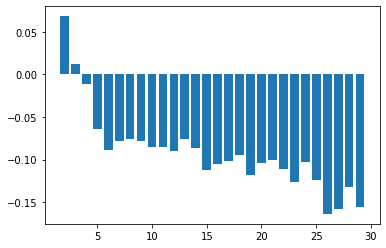

10-5dim
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 472)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                4730      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_4 (Dense)              (None, 472)               5192      
Total params: 10,037
Trainable params: 10,037
Non-trainable params: 0
_________________________________________________________________
Train on 132 samples, validate on 33 samples
Epoch 1/100
132/132 [==============================] - 0s 965us/step

Epoch 70/100
132/132 [==============================] - 0s 78us/step - loss: 0.0871 - val_loss: 0.1044
Epoch 71/100
132/132 [==============================] - 0s 74us/step - loss: 0.0866 - val_loss: 0.1037
Epoch 72/100
132/132 [==============================] - 0s 78us/step - loss: 0.0861 - val_loss: 0.1031
Epoch 73/100
132/132 [==============================] - 0s 73us/step - loss: 0.0856 - val_loss: 0.1026
Epoch 74/100
132/132 [==============================] - 0s 73us/step - loss: 0.0851 - val_loss: 0.1020
Epoch 75/100
132/132 [==============================] - 0s 72us/step - loss: 0.0846 - val_loss: 0.1015
Epoch 76/100
132/132 [==============================] - 0s 68us/step - loss: 0.0842 - val_loss: 0.1010
Epoch 77/100
132/132 [==============================] - 0s 74us/step - loss: 0.0838 - val_loss: 0.1006
Epoch 78/100
132/132 [==============================] - 0s 71us/step - loss: 0.0834 - val_loss: 0.1002
Epoch 79/100
132/132 [==============================] - 0s 70us/step - lo

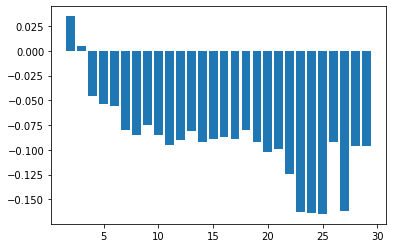

In [13]:
# Grid search
for middle_dim in search_list1:
    for encoding_dim in [i for i in search_list2 if i < middle_dim]:
        training(middle_dim, encoding_dim)

# Silhouette Score 

In [ ]:
ls = os.listdir('./score/grid_step5_2/')
ls.sort()
ls

In [ ]:
rows = []
for file in ls:
    name = file.split('.')[0]
    score = read_json('./score/'+ SAVE_FOLDER + file)
    rows.append([name] + score)

In [ ]:
score_df = pd.DataFrame(rows, columns = range(1, 30))
score_df

In [ ]:
score_df.to_csv('./output/score_df_grid_step5_2.csv', index = 0)